<a href="https://colab.research.google.com/github/FinnHendricks/YOLO_ConeDetection/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FinnHendricks/YOLO_ConeDetection/blob/main/train.ipynb)

In [1]:
partial_dataset = True
load_model = False

from google.colab import drive
drive.mount('/content/gdrive')

model_path = "/content/gdrive/MyDrive/YOLO_cone/model"

Mounted at /content/gdrive



## Steps:
- basic CNN architecture / class - ok
- input pipeline - ok
- visualisation - ok
- IoU - ok
- 2 BB per cell
- Loss function
- non maxima suppression
- Train/optimizer
- training
- better architecture, batch_norm
- augmentation

- result: sigmoid on center + exponent of w+h

## General steps:
- Yolo on cones / on COCO
- introduce different scales
- Yolo on COCO
- introduce anchor boxes
- CARLA data
- Yolo on Carla

## yolo-format (called label(s) in this notebook:
- each image has its own label file with the same file name
- each cone of an image is described by one line
- Format in txt files: class, x_center, y_center, width_bbox, height_bbox
- Format used in this notebook: [objectness, x_center, y_center, width_bbox, height_bbox, class0, c1, c2, c3, c4, c5, c6]

- 0 blue
- 1 yellow
- 2 orange-small
- 3 orange-big (shown in red)
- 4 yellow-big (shown in white)
- 5 green
- 6 lying

## YOLO-Output (called y / y_pred / y_true in this notebook:

Per S x S grid cell, e.g. 8x8:
x,y, height, width, objectness, prob per class

--> 8x8x(4+1+7) = 8x8x12 = 768 output neurons


In [2]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [3]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

print(tf.config.list_physical_devices())
print(tf.__version__)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.6.0
Tue Oct 26 09:19:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+----------------------------

In [4]:
%%capture
if partial_dataset:
    !unzip -u "/content/gdrive/MyDrive/cones_multi_class_partial.zip" -d "/content/";
    directory_train = '/content/cones_multi_class_partial/train/'
    directory_test = '/content/cones_multi_class_partial/test/'
    train_size = 128
    batch_size = 8
else:
    !unzip -u "/content/gdrive/MyDrive/cones_multi_class.zip" -d "/content/";
    directory_train = '/content/cones_multi_class/train/'
    directory_test = '/content/cones_multi_class/test/'
    train_size = 21_067 - 14  
    batch_size = 32

In [5]:

img_width = 512#800
img_height = 512#320
img_channels = 3

grid_X = 16
grid_Y = 16
num_classes = 7  # blue, yellow, orange_small, o_big, yellow, green, lying
anchor_size = num_classes + 5

epochs = 5
initial_learning_rate = 0.01
#final_learning_rate = 0.001
#learning_rate_decay_factor = (final_learning_rate / initial_learning_rate) ** (1/epochs)
steps_per_epoch = int(train_size/batch_size)


In [6]:
# convert the label given in the csv files to a matrix that can be used as y

def convert_label_to_y(label, file):
    object_class, x_center, y_center, width_bbox, height_bbox = list(map(float, label))

    # find relevant grid cell for predicting the object
    i, j = int(y_center * grid_Y), int(x_center * grid_X) # i row, j column 

    assert i < grid_Y, "center must be within the image" + str(file.name)
    assert j < grid_X, "center must be within the image" + str(file.name)

    x_center_bbox = x_center * grid_X - j  # find center relative to cell; 0...1
    y_center_bbox = y_center * grid_Y - i

    width_bbox *= grid_X  # scale box size, that 1 equals the grid size -> range of object size makes more sense
    height_bbox *= grid_Y

    c0, c1, c2, c3, c4, c5, c6 = tf.one_hot(tf.range(7), 7)[int(object_class)] # class of the cone
    # objectness, x_center, y_center, width_bbox, height_bbox, class0, c1, c2, c3, c4, c5, c6
    y = [1.0, x_center_bbox, y_center_bbox, width_bbox, height_bbox, c0, c1, c2, c3, c4, c5, c6]
    return y, i, j

In [7]:
black_list_files_train = ["00001505_skid-pad.txt", 
                    "Renningen_08_04_video_second_frame_8.txt", 
                    "Aidlingen_07_12_video_first_frame_4.txt",
                    "Aidlingen_07_12_video_first_frame_8.txt",
                    "upbracing-classes.txt",
                    "00001833_skid-pad.txt",
                    "00047.txt",
                    "Aidlingen_07_12_video_first_frame_7.txt",
                    "00001465_skid-pad.txt",
                    "Aidlingen_07_12_video_first_frame_5.txt",
                    "Aidlingen_07_12_video_first_frame_6.txt",
                    "213(2).txt",
                    "Aidlingen_07_12_video_first_frame_3.txt",
                    "00001464_skid-pad.txt"
                    ]  
                    # the labels of this samples are currupt and may not be used

black_list_files_test = []

def read_data(path, black_list_files=None):
    if black_list_files is None:
        black_list_files = []
    jpg_paths = []
    n_samples = 0
    for file in os.listdir(path):
        if file.endswith(".txt"):
            n_samples += 1
    n_samples -= len(black_list_files)

    sample_ctr = 0
    y = np.zeros((n_samples, grid_X, grid_Y, anchor_size))
    for file in os.listdir(path):
        if file.endswith(".txt"):
          
            if file in black_list_files:
                continue
            #try:
            with open(os.path.join(path, file), "r") as file:
                for label in file:
                    label = label.strip().split(" ")
                    cone, i, j = convert_label_to_y(label, file) 
                    
                    if y[sample_ctr, j, i, 0] == 0:
                        # no cone is stored at the grid cell, yet
                        y[sample_ctr, j, i, :] = cone
                    # else:
                        # slot already full- don´t write the cone
                        # print("No space to store the cone. Cone will be dismissed. File: ", file.name, i,j)
                        # think about dismissing the whole image and don´t use it for training
                        
            #except:
            #    print(str(file))
            #    continue
            #find the corresponding image path
            jpg_path = file.name.strip("txt")+"jpg"
            jpg_paths.append(jpg_path)
            sample_ctr += 1
            
    return jpg_paths, y

if partial_dataset:
    jpg_paths_train, y_train = read_data(directory_train)
    jpg_paths_test, y_test = read_data(directory_test)  
else:           
    jpg_paths_train, y_train = read_data(directory_train, black_list_files_train)
    jpg_paths_test, y_test = read_data(directory_test)
print(y_train.shape[0], " train images found.")
print(y_test.shape[0], " test images found.")



128  train images found.
32  test images found.


In [8]:
# input data

ds_train = tf.data.Dataset.from_tensor_slices((jpg_paths_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((jpg_paths_test, y_test))

def read_image(image_file, y):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)#, dtype=tf.float32)
    return image, y

def resize(image, y):
    image = tf.image.resize(image, [img_height, img_width], method=tf.image.ResizeMethod.BILINEAR,preserve_aspect_ratio=False)
    image = image / 255. # rescale
    return image, y


#ds_train = ds_train.map(read_image).map(resize_and_crop).map(augment).batch(batch_size)
ds_train = ds_train.map(read_image).map(resize).shuffle(train_size).batch(batch_size).prefetch(2)
ds_test = ds_test.map(read_image).map(resize).batch(batch_size)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


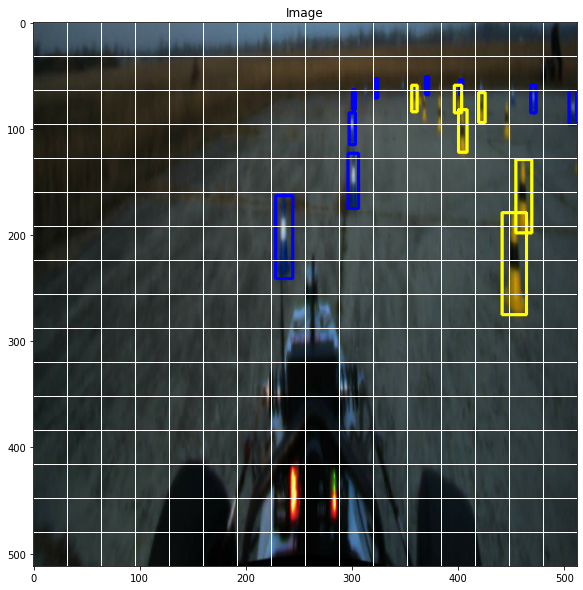

In [68]:
def visualize(image):
    fig = plt.figure(figsize=(10,10))
    plt.title('Image')
    plt.imshow(image)


def draw_bounding_box(image, y, draw_grid=True):
    image = image.numpy()
    h, w, _ = image.shape   
        
    relevant_grids = np.argwhere(y[:,:,0] >= 0.3)  # get relevant grids that contain objects with objectness > 0.3 
    for grid in relevant_grids:
        objectness, x_center_bbox, y_center_bbox, width_bbox, height_bbox = y[list(grid)][:5]
        #blue, yellow, orange, orange-big, yellow-big, green, lying
        object_class = y[list(grid)][5:]
        object_class = np.argmax(object_class) 

        #Todo: class when not 0 / 1
        colors = {
            0: [0, 0, 255],
            1: [255, 255, 0],
            2: [255, 165, 0],
            3: [255, 0  , 0],
            4: [255, 255, 255],
            5: [0  , 255, 0],
            6: [0  , 0  , 0]
        }
        color = colors[object_class]
        color = color * objectness  # adjust brightness based on objectness

        color = tf.make_tensor_proto(color)
        color = tf.make_ndarray(color).astype(int).tolist()
    
        x_center = (x_center_bbox + grid[0])/grid_X*w
        y_center = (y_center_bbox + grid[1])/grid_Y*h
        box_width = width_bbox / grid_X * w
        box_height = height_bbox / grid_Y * h
        
        x_min = int(x_center - box_width/2)
        x_max = int(x_center + box_width/2)
        y_min = int(y_center - box_height/2)
        y_max = int(y_center + box_height/2)
        
        image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2) 
    if draw_grid:
        grid_points = [[(int(i/grid_X*w), 0),(int(i/grid_X*w), h)]for i in range(grid_X)] + \
                      [[(0, int(i/grid_Y*h)),(w, int(i/grid_Y*h))]for i in range(grid_Y)]
        for points in grid_points: 
            cv2.line(image, points[0], points[1], [255, 255, 255], 1) 

    return image

for images, y in ds_train:
    #print(images.shape)
    i = np.random.randint(0, batch_size)
    image = draw_bounding_box(images[i], y[i], draw_grid=True)
    visualize(image)
    break

In [29]:
input_layer = keras.layers.Input(shape=(img_width, img_height, img_channels))
x = keras.layers.Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same')(input_layer)
x = keras.layers.Conv2D(64, (3, 3), strides=(1,1), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(64, (3, 3), strides=(1,1), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(128, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(128, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(128, (3, 3), strides=(1,1), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(256, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(256, (3, 3), strides=(1,1), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(512, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(1024, (1, 1), strides=(1,1), activation='relu', padding='same')(x)
# using just a single anchor
out_channels = anchor_size  # [objectness, x_center, y_center, width_bbox, height_bbox, class0, c1, c2, c3, c4, c5, c6]
outputs = keras.layers.Conv2D(out_channels, (1, 1), strides=(1,1), activation='linear', padding='same')(x)




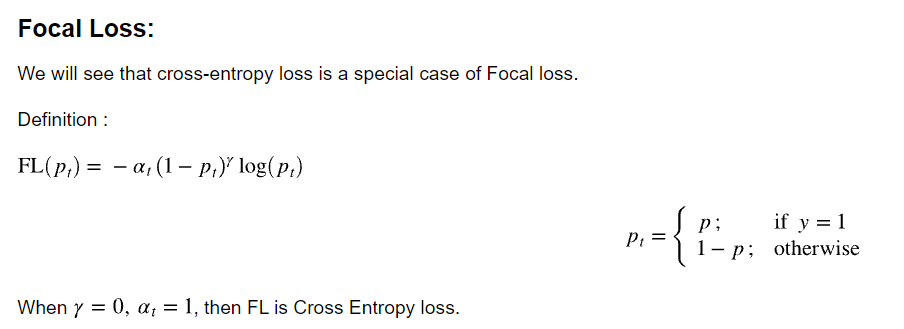

In [77]:

def loss_yolo_v1(y, y_pred):
    # objectness
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    mse = tf.keras.losses.MeanSquaredError()
    sfc = tfa.losses.SigmoidFocalCrossEntropy()
    # obj_weight = tf.ones_like(y[...,0])*0.1 + y[...,0]*10
    # obj_loss = bce(y[...,0], y_pred[...,0])*obj_weight
    obj_loss = sfc(y[...,0], y_pred[...,0])
    loss = tf.reduce_sum(obj_loss) #+ tf.math.reduce_sum(box_loss)
    return loss

# Instantiate the model
if load_model:
    model = keras.models.load_model(model_path, custom_objects={'loss_yolo_v1': loss_yolo_v1})

else:
    model = keras.Model(inputs=input_layer, outputs=outputs)
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss=loss_yolo_v1)

# print(model.summary())


model.fit(
    ds_train,
    epochs=20,
    verbose=2,
    # Only run validation using the first 10 batches of the dataset
    # using the `validation_steps` argument
    validation_data=ds_test,
    validation_steps=1
)
model.save(model_path)

Epoch 1/20
16/16 - 5s - loss: 33.2266 - val_loss: 21.3341
Epoch 2/20
16/16 - 4s - loss: 29.1891 - val_loss: 21.0215
Epoch 3/20
16/16 - 4s - loss: 28.5708 - val_loss: 20.4532
Epoch 4/20
16/16 - 4s - loss: 28.7654 - val_loss: 19.9015
Epoch 5/20
16/16 - 4s - loss: 28.7207 - val_loss: 20.0274
Epoch 6/20
16/16 - 4s - loss: 28.6061 - val_loss: 19.9707
Epoch 7/20
16/16 - 4s - loss: 28.6102 - val_loss: 19.6343
Epoch 8/20
16/16 - 4s - loss: 28.5620 - val_loss: 20.6078
Epoch 9/20
16/16 - 4s - loss: 28.6165 - val_loss: 19.8524
Epoch 10/20
16/16 - 4s - loss: 28.8363 - val_loss: 19.5364
Epoch 11/20
16/16 - 4s - loss: 28.6308 - val_loss: 20.2213
Epoch 12/20
16/16 - 4s - loss: 28.6057 - val_loss: 20.0187
Epoch 13/20
16/16 - 4s - loss: 28.5987 - val_loss: 20.2707
Epoch 14/20
16/16 - 4s - loss: 28.6891 - val_loss: 19.5845
Epoch 15/20
16/16 - 4s - loss: 28.7350 - val_loss: 20.2559
Epoch 16/20
16/16 - 4s - loss: 28.6399 - val_loss: 20.3454
Epoch 17/20
16/16 - 4s - loss: 28.5929 - val_loss: 20.2691
Epoch 

In [80]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=loss_yolo_v1)
model.fit(
    ds_train,
    epochs=10,
    verbose=2,
    # Only run validation using the first 10 batches of the dataset
    # using the `validation_steps` argument
    validation_data=ds_test,
    validation_steps=1
)

Epoch 1/10
16/16 - 5s - loss: 28.4870 - val_loss: 20.2269
Epoch 2/10
16/16 - 4s - loss: 28.4921 - val_loss: 20.0426
Epoch 3/10
16/16 - 4s - loss: 28.4842 - val_loss: 20.0168
Epoch 4/10
16/16 - 4s - loss: 28.4608 - val_loss: 20.0184
Epoch 5/10
16/16 - 4s - loss: 28.4665 - val_loss: 19.9611
Epoch 6/10
16/16 - 4s - loss: 28.4719 - val_loss: 20.1234
Epoch 7/10
16/16 - 4s - loss: 28.4878 - val_loss: 20.1158
Epoch 8/10
16/16 - 4s - loss: 28.4778 - val_loss: 20.0043
Epoch 9/10
16/16 - 4s - loss: 28.4806 - val_loss: 20.1651
Epoch 10/10
16/16 - 4s - loss: 28.4668 - val_loss: 20.0592


In [ ]:

    # bboxes as GIoU
    x_center_pred = y_pred[...,1]
    y_center_pred = y_pred[...,2]
    width_pred = y_pred[...,3]
    height_pred = y_pred[...,4]

    x_center = y[...,1]
    y_center = y[...,2]
    width = y[...,3]
    height = y[...,4]

    x_min_pred = x_center_pred - width_pred/2
    x_max_pred = x_center_pred + width_pred/2
    y_min_pred = y_center_pred - height_pred/2
    y_max_pred = y_center_pred + height_pred/2

    x_min = x_center - width/2
    x_max = x_center + width/2
    y_min = y_center - height/2
    y_max = y_center + height/2

    box = tf.stack([y_min, x_min, y_max, x_max], axis=3)
    #print("1box", box.shape)
    #box = tf.transpose(box, [3, 0, 1, 2])
    #print("2box", box.shape)
    box = tf.reshape(box, [-1, 4])
    #print("3box", box.shape)

    box_pred = tf.stack([y_min_pred, x_min_pred, y_max_pred, x_max_pred], axis=3)
    #box_pred = tf.transpose(box_pred, [3, 0, 1, 2])
    box_pred = tf.reshape(box_pred, [-1, 4])
    
    # only use loss for bboxes where y has an objectness of 1

    #tf.print(box.shape)
    #tf.print(y[...,0].shape)
    #tf.print(tf.reshape(y[...,0], [-1]))#, tf.where(tf.reshape(y[...,0], -1))[:,0].shape)
    box = tf.gather(box, tf.where(tf.reshape(y[...,0], [-1]))[:,0], axis=0)
    box_pred = tf.gather(box_pred, tf.where(tf.reshape(y[...,0], [-1]))[:,0], axis=0)
    #tf.print("4box", box.shape)
    
    #tf.print("box_pred", box_pred.shape)
    gl = tfa.losses.GIoULoss()
    #tf.print("gl", gl)

    box_loss = gl(box, box_pred)


(1, 512, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 16, 16, 12)


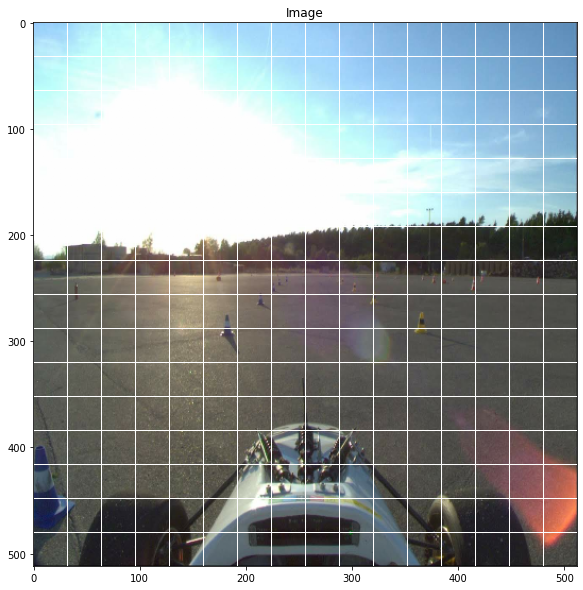

In [78]:
y_pred = 0
for images, y in ds_train:
    print(np.array([images[0]]).shape)

    y_pred = model.predict(np.array([images[0]])) 
    print(y_pred.shape)
    image = draw_bounding_box(images[0], y_pred, draw_grid=True)
    #image = draw_bounding_box(images[0], y[0], draw_grid=True)
    visualize(image)
    break




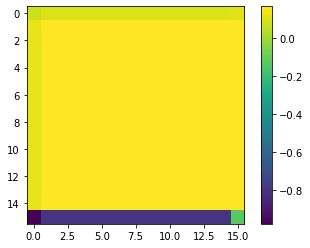

In [79]:
plt.imshow(y_pred[0,:,:,0].T)
plt.colorbar()

In [ ]:
y.shape
x_center_bbox = y[...,1]
y_center_bbox = y[...,2]
box_width = y[...,3]
box_height = y[...,4]


x_min = x_center_bbox - box_width/2
x_max = x_center_bbox + box_width/2
y_min = y_center_bbox - box_height/2
y_max = y_center_bbox + box_height/2

box = tf.stack([y_min, x_min, y_max, x_max], axis=3)
box = tf.transpose(box, [3, 0, 1, 2])
box = tf.reshape(box, [4,-1])
box.shape

In [ ]:
filename_show = directory_train + "00000001_low-pose_curves.txt"

y = np.zeros((8, grid_X, grid_Y, anchor_size))
with open(filename_show, "r") as file:
    for label in file:
        label = label.strip().split(" ")
        cone, i, j = convert_label_to_y(label, file) 
        
        if y[0, j, i, 0] == 0:
            # no cone is stored at the grid cell, yet
            y[0, j, i, :] = cone
y.shape

In [ ]:
jpg_show = filename_show.strip("txt")+"jpg"
ds_show = tf.data.Dataset.from_tensor_slices((jpg_show, y))
ds_show = ds_show.map().map(resize)


for images, y in show_img:
    #print(images.shape)
    i = np.random.randint(0, batch_size)
    image = draw_bounding_box(images[i], y[i], draw_grid=True)
    visualize(image)
    break

In [ ]:
tf.where(tf.reshape(y[...,0], [-1]))

In [ ]:
tf.reshape(y[...,0], [-1])

In [ ]:
tf.where(tf.reshape(y[...,0], [-1]))[:,0]

In [ ]:
box = tf.gather(tf.reshape(y, [-1, 12]), tf.where(tf.reshape(y[...,0], [-1]))[:,0], axis=0)
print(box.shape)


x_center_bbox = box[:,1]
y_center_bbox = box[:,2]
box_width = box[:,3]
box_height = box[:,4]

x_min = x_center_bbox - box_width/2
x_max = x_center_bbox + box_width/2
y_min = y_center_bbox - box_height/2
y_max = y_center_bbox + box_height/2

In [ ]:
x_min

In [ ]:
x_max

In [ ]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    mse = tf.keras.losses.MeanSquaredError()
    obj_weight = tf.ones_like(y[...,0])*0.01 + y[...,0]*100
    obj_loss = mse(y[...,0], y_pred[...,0])*obj_weight

    # bboxes as GIoU
    
    #box_loss = mse(y[...,1:5], y_pred[...,1:5])*box_weight

    x_center_bbox_pred = y_pred[...,1]
    y_center_bbox_pred = y_pred[...,2]
    box_width_pred = y_pred[...,3]
    box_height_pred = y_pred[...,4]

    x_center_bbox = y[...,1]
    y_center_bbox = y[...,2]
    box_width = y[...,3]
    box_height = y[...,4]

    x_min_pred = x_center_bbox_pred - box_width_pred/2
    x_max_pred = x_center_bbox_pred + box_width_pred/2
    y_min_pred = y_center_bbox_pred - box_height_pred/2
    y_max_pred = y_center_bbox_pred + box_height_pred/2

    x_min = x_center_bbox - box_width/2
    x_max = x_center_bbox + box_width/2
    y_min = y_center_bbox - box_height/2
    y_max = y_center_bbox + box_height/2

    box = tf.stack([y_min, x_min, y_max, x_max], axis=3)
    #print("1box", box.shape)
    #box = tf.transpose(box, [3, 0, 1, 2])
    #print("2box", box.shape)
    box = tf.reshape(box, [-1, 4])
    #print("3box", box.shape)

    box_pred = tf.stack([y_min_pred, x_min_pred, y_max_pred, x_max_pred], axis=3)
    #box_pred = tf.transpose(box_pred, [3, 0, 1, 2])
    box_pred = tf.reshape(box_pred, [-1, 4])
    
    # only use loss for bboxes where y has an objectness of 1

    #tf.print(box.shape)
    #tf.print(y[...,0].shape)
    #tf.print(tf.reshape(y[...,0], [-1]))#, tf.where(tf.reshape(y[...,0], -1))[:,0].shape)
    box = tf.gather(box, tf.where(tf.reshape(y[...,0], [-1]))[:,0], axis=0)
    box_pred = tf.gather(box_pred, tf.where(tf.reshape(y[...,0], [-1]))[:,0], axis=0)
    #tf.print("4box", box.shape)
    
    #tf.print("box_pred", box_pred.shape)
    gl = tfa.losses.GIoULoss()
    #tf.print("gl", gl)

    # input for GIoU: [y_min, x_min, y_max, x_max].
    #boxes1 = tf.constant([[0.0, 0.0, 1.0, 1.0]])#, [5.0, 6.0, 10.0, 7.0]])
    #boxes2 = tf.constant([[-5.0, -5.0, -2.0, -2.0]])#, [14.0, 14.0, 15.0, 15.0]])
    box_loss = gl(box, box_pred)
    #print("box loss", box_loss.shape)
    #print(loss)



    # classes
    ce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    class_pred = y_pred[...,5:]
    class_pred = tf.gather(class_pred, tf.where(tf.reshape(y[...,0], [-1]))[:,0], axis=0)
    class_true = y[...,5:]
    #tf.print(class_true.shape, class_true)
    class_pred = tf.gather(class_true, tf.where(tf.reshape(y[...,0], [-1]))[:,0], axis=0)
    #tf.print(class_true.shape, class_true)
    class_loss = ce(class_true, class_pred)

    loss = tf.math.reduce_sum(obj_loss) + tf.math.reduce_sum(box_loss) + tf.math.reduce_sum(class_loss)
  

In [ ]:
########################

## loss function storage

   

    """i, j = int(y_center * grid_Y), int(x_center * grid_X) # i row, j column 

    x_center_bbox = x_center * grid_X - j  # find center relative to cell; 0...1
    y_center_bbox = y_center * grid_Y - i

    width_bbox *= grid_X  # scale box size, that 1 equals the grid size -> range of object size makes more sense
    height_bbox *= grid_Y
    
    y = [1.0, x_center_bbox, y_center_bbox, width_bbox, height_bbox, c0, c1, c2, c3, c4, c5, c6]

    x_center = (x_center_bbox + grid[0])/grid_X*w
        y_center = (y_center_bbox + grid[1])/grid_Y*h
        box_width = width_bbox / grid_X * w
        box_height = height_bbox / grid_Y * h
        
        x_min = int(x_center - box_width/2)
        x_max = int(x_center + box_width/2)
    """
    # x_center is relative to the cell

    # objectness
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    mse = tf.keras.losses.MeanSquaredError()
    obj_weight = tf.ones_like(y[...,0])*0.1 + y[...,0]*10
    obj_loss = bce(y[...,0], y_pred[...,0])*obj_weight

    # bboxes as GIoU
    
    #box_loss = mse(y[...,1:5], y_pred[...,1:5])*box_weight

    x_center_bbox_pred = y_pred[...,1]
    y_center_bbox_pred = y_pred[...,2]
    box_width_pred = y_pred[...,3]
    box_height_pred = y_pred[...,4]

    x_center_bbox = y[...,1]
    y_center_bbox = y[...,2]
    box_width = y[...,3]
    box_height = y[...,4]

    x_min_pred = x_center_bbox_pred - box_width_pred/2
    x_max_pred = x_center_bbox_pred + box_width_pred/2
    y_min_pred = y_center_bbox_pred - box_height_pred/2
    y_max_pred = y_center_bbox_pred + box_height_pred/2

    x_min = x_center_bbox - box_width/2
    x_max = x_center_bbox + box_width/2
    y_min = y_center_bbox - box_height/2
    y_max = y_center_bbox + box_height/2

    box = tf.stack([y_min, x_min, y_max, x_max], axis=3)
    #print("1box", box.shape)
    #box = tf.transpose(box, [3, 0, 1, 2])
    #print("2box", box.shape)
    box = tf.reshape(box, [-1, 4])
    #print("3box", box.shape)

    box_pred = tf.stack([y_min_pred, x_min_pred, y_max_pred, x_max_pred], axis=3)
    #box_pred = tf.transpose(box_pred, [3, 0, 1, 2])
    box_pred = tf.reshape(box_pred, [-1, 4])
    
    # only use loss for bboxes where y has an objectness of 1

    #tf.print(box.shape)
    #tf.print(y[...,0].shape)
    #tf.print(tf.reshape(y[...,0], [-1]))#, tf.where(tf.reshape(y[...,0], -1))[:,0].shape)
    box = tf.gather(box, tf.where(tf.reshape(y[...,0], [-1]))[:,0], axis=0)
    box_pred = tf.gather(box_pred, tf.where(tf.reshape(y[...,0], [-1]))[:,0], axis=0)
    #tf.print("4box", box.shape)
    
    #tf.print("box_pred", box_pred.shape)
    gl = tfa.losses.GIoULoss()
    #tf.print("gl", gl)

    # input for GIoU: [y_min, x_min, y_max, x_max].
    #boxes1 = tf.constant([[0.0, 0.0, 1.0, 1.0]])#, [5.0, 6.0, 10.0, 7.0]])
    #boxes2 = tf.constant([[-5.0, -5.0, -2.0, -2.0]])#, [14.0, 14.0, 15.0, 15.0]])
    box_loss = gl(box, box_pred)
    #print("box loss", box_loss.shape)
    #print(loss)



    # classes
    ce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    class_pred = y_pred[...,5:]
    class_pred = tf.gather(class_pred, tf.where(tf.reshape(y[...,0], [-1]))[:,0], axis=0)
    class_true = y[...,5:]
    #tf.print(class_true.shape, class_true)
    class_pred = tf.gather(class_true, tf.where(tf.reshape(y[...,0], [-1]))[:,0], axis=0)
    #tf.print(class_true.shape, class_true)
    class_loss = ce(class_true, class_pred)

    loss = tf.math.reduce_sum(obj_loss) #+ tf.math.reduce_sum(box_loss) + tf.math.reduce_sum(class_loss)
    # -----------------------------------------------------------------------

    # first, find a mapping for each grid cell, which anchor 
    # objectness for each grid cell -> required to surpress ghost objects


    # x/y/w/h as GIoU only where y_pred has an object
    # select which bbox_pred belongs to which bbox_true based on minimizing the overall GIoU
    
    # class prob. only where y_pred has an object
    # other than in the paper, classes should be available for each object


    